In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re
from datetime import datetime, timedelta
import math
from scipy import stats

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
df = pd.read_csv('main_task_new.csv')
#приведем все названия столбцов к единому формату
df.columns = df.columns.str.replace(' ', '_') 
df.columns = df.columns.str.lower()
df.head(3)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


в исходной базе данных достаточно "грязные" данные, которые необходимо предварительно обработать

пропуски в кухнях обработаем в ходе дальнейшего преобразования датафрейма

In [117]:
df.duplicated(subset=None, keep='first').value_counts() #дублей в коде нет

False    40000
dtype: int64

In [5]:
#для предварительной оценки МАЕ исходных данных (чтобы отследить прогресс) обработаем пропуски в Number of Reviews
 #пропуски заполняем значением моды, т.к. данные очень разбросаны
rev_mode = stats.mode(df['number_of_reviews']) #= ModeResult(mode=array([2.]), count=array([1916]))
df['number_of_reviews'] = df['number_of_reviews'].fillna(2) 

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  40000 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [243]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
# X = df.drop(['Restaurant_id', 'Rating'], axis = 1) 
X = df.drop(['restaurant_id', 'rating','city','cuisine_style','price_range','reviews','url_ta','id_ta'], axis = 1)
x_mean = np.mean(X['number_of_reviews']) 
X['number_of_reviews'] = X['number_of_reviews'].fillna(x_mean) #удаляем пропуски в серии:  
y = df['rating'] 

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X

,ranking,number_of_reviews
0,5570.0,194.0
1,1537.0,10.0
2,353.0,688.0
3,3458.0,3.0
4,621.0,84.0
...,...,...
39995,500.0,79.0
39996,6341.0,542.0
39997,1652.0,4.0
39998,641.0,70.0


In [244]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

#для отслеживания прогресса создадим список, куда будем складывать каждый результат МАЕ
list_MAE = []
list_MAE.append(metrics.mean_absolute_error(y_test, y_pred)) #добавили первый МАЕ в список
print('MAE:', metrics.mean_absolute_error(y_test, y_pred)) 

MAE: 0.4272386701479077


In [136]:
list_MAE

[0.4289599380952381]

обработка ячеек для дальнейшего усовершенствования МАЕ

In [248]:
#сумма чека/цена представлена 3мя категориями
df['price_range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

In [146]:
#также здесь присутствуют пропуски, которое заменим наиболее частым значением (модой) -"$$ - $$$"
df['price_range'].isna().sum()
# stats.mode(df['price_range'])

13886

In [29]:
#сумма чека/цена представлена 3мя категориями, приведем их к ранжированию
df['price_range'] = df['price_range'].fillna('$$ - $$$')#заменяем пропуски на "$$ - $$$"

def range_price(x): #разделим цену на ранги
    if x == '$':
        return 1.0 #низкая цена
    elif x == '$$ - $$$':
        return 2.0 #средняя цена
    elif x == '$$$$':
        return 3.0 #высокая цена
    else:
        return 0
df['range_of_price'] = df['price_range'].apply(range_price)
df['range_of_price'].value_counts()

2.0    32298
1.0     6279
3.0     1423
Name: range_of_price, dtype: int64

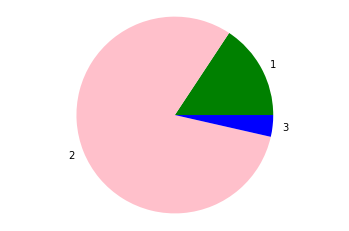

In [192]:
#визуально это выглядит так
values = []
labels = []
for x in range(1, len(df['range_of_price'].value_counts())+1):
    values.append(df['range_of_price'].value_counts()[x])
    labels.append(x)
colors = ['green','pink','blue']
plt.pie(values, labels = labels, colors = colors)
plt.axis('equal')
plt.show()

In [14]:
#разберемся с кухнями. Данные содержат много "лишних" знаков, поэтому для начала надо их очистить
df['cuisine_style'] = df['cuisine_style'].str.strip()
def cuisine_to_list(string): #убираем лишние кавычки, скобки и т.д
    if pd.isnull(string):
        return []
    else:
        string = string.replace('"', '')
        string = string.replace('[', '')
        string = string.replace(']', '')
        string = string.replace("'", '')
        return string.split(', ')
df['cuisine_style_list'] = df['cuisine_style'].apply(cuisine_to_list) #"очищенный" список кухонь в каждом ресторане
df['cuisine_style_list'].head(5)

0                    [European, French, International]
1                                                   []
2    [Japanese, Sushi, Asian, Grill, Vegetarian Fri...
3                                                   []
4      [German, Central European, Vegetarian Friendly]
Name: cuisine_style_list, dtype: object

In [15]:
# подсчитаем количество кухноь в каждом ресторане. В случае, если данных нет, считаем что в ресторане один вид кухни
df['cuisine_count'] = df['cuisine_style_list'].apply(lambda x: len(x))
df.loc[(df['cuisine_count'] == 0),'cuisine_count'] = 1
df['cuisine_count']

0        3
1        1
2        7
3        1
4        3
        ..
39995    4
39996    5
39997    2
39998    5
39999    1
Name: cuisine_count, Length: 40000, dtype: int64

In [18]:
# подсчитаем общее количество кухонь в датасете
total_cuisine = df['cuisine_style_list'].explode().value_counts().count()

total_cuisine

125

In [16]:
# узнаем самые популярные
top_cuisine = df['cuisine_style_list'].explode()
top10_cuisine = Counter(top_cuisine).most_common()
top10_cuisine

[('Vegetarian Friendly', 11189),
 ('European', 10060),
 (nan, 9283),
 ('Mediterranean', 6277),
 ('Italian', 5964),
 ('Vegan Options', 4486),
 ('Gluten Free Options', 4113),
 ('Bar', 3297),
 ('French', 3190),
 ('Asian', 3011),
 ('Pizza', 2849),
 ('Spanish', 2798),
 ('Pub', 2449),
 ('Cafe', 2325),
 ('Fast Food', 1705),
 ('British', 1595),
 ('International', 1584),
 ('Seafood', 1505),
 ('Japanese', 1464),
 ('Central European', 1393),
 ('American', 1315),
 ('Sushi', 1156),
 ('Chinese', 1145),
 ('Portuguese', 1107),
 ('Indian', 1041),
 ('Middle Eastern', 782),
 ('Thai', 743),
 ('Wine Bar', 697),
 ('German', 662),
 ('Healthy', 620),
 ('Greek', 604),
 ('Halal', 598),
 ('Czech', 595),
 ('Fusion', 577),
 ('Steakhouse', 573),
 ('Barbecue', 555),
 ('Contemporary', 523),
 ('Vietnamese', 513),
 ('Eastern European', 496),
 ('Soups', 494),
 ('Grill', 490),
 ('Gastropub', 471),
 ('Mexican', 445),
 ('Turkish', 444),
 ('Delicatessen', 392),
 ('Austrian', 380),
 ('South American', 372),
 ('Polish', 365),

In [19]:
total_cuisine_list = df['cuisine_style_list'].explode()
cuisines = set()  # создаём пустое множество для хранения уникальных значений кухонь
for x in total_cuisine_list: 
    cuisines.add(x) # добавляем название типа кухни к множеству
cuisines

{'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun & Creole',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mexic

In [49]:
#в серии с отзывами находятся данные о датах отзыва. для их обработки надо их вывестив отдельный признак
def date_time (time):
    regex = re.compile('\'\d+\/\d+\/\d+\'?') #с помощью регулярных выражений задаем критерий поиска
    dates = regex.findall(time) #заносим в переменную результат поиска
    new_list_date = []
    for date in dates:
        date = date[1:-1]
        dt = datetime.strptime(date, '%m/%d/%Y')
        new_list_date.append(dt)
    return new_list_date
df['time_reviews'] = df['reviews'].apply(lambda x: date_time(x))

df['time_reviews'] = df['time_reviews'].apply(lambda x: None if len(x)==0 else x)
df['date1'] = df['time_reviews'].apply(lambda x: None if x == None else x[0]) 
df['date2'] = df['time_reviews'].apply(lambda x: None if x == None else x[-1])

def day_week(x): # вычисляем средний день недели посещения (считаем, что люди написали отзыв тогда же, когда и были в заведении)
    x =  x.weekday()
    return x
df['date2'] = pd.to_datetime(df['date2'])
df['date1'] = pd.to_datetime(df['date1'])

df['date1_week'] = df['date1'].dt.weekday
df['date2_week'] = df['date2'].dt.weekday
df[['date1','date2', 'date1_week', 'date2_week']]

,date1,date2,date1_week,date2_week
0,2017-12-31,2017-11-20,6.0,0.0
1,2017-07-06,2016-06-19,3.0,6.0
2,2018-01-08,2018-01-06,0.0,5.0
3,NaT,NaT,NaN,NaN
4,2017-11-18,2017-02-19,5.0,6.0
...,...,...,...,...
39995,2017-12-16,2017-11-12,5.0,6.0
39996,2017-12-21,2017-12-12,3.0,1.0
39997,2016-11-03,2008-04-12,3.0,5.0
39998,2017-07-11,2017-06-18,1.0,6.0


In [50]:
def dates_dif(row):
    if row is None:
        return None
    elif len(row) == 2:
        first = row[0]
        second = row[1]
        if first > second:
            dif = (first - second).days
        else:
            dif = (second - first).days
        return dif
    else:
        return None
df['dif_dates'] = df['time_reviews'].apply(dates_dif)
mean_days = df['dif_dates'].mean()
df['dif_dates'] = df['dif_dates'].fillna(round(mean_days, 0))
df['dif_dates'].max() #Какое максимальное количество дней отделяет даты публикации отзывов, размещённых на сайте ресторана? Введите количество дней в виде целого числа.

3207.0

проверим промежуточный МАЕ, но сначала посмотрим наличие пропусков в новых признаках

In [32]:
df.isna().sum()

restaurant_id            0
city                     0
cuisine_style         9283
ranking                  0
rating                   0
price_range              0
number_of_reviews        0
reviews                  0
url_ta                   0
id_ta                    0
range_of_price           0
cuisine_style_list       0
cuisine_count            0
time_reviews          6471
date1                 6471
date2                 6471
date1_week            6471
date2_week            6471
dif_dates                0
dtype: int64

пропусками в time_reviews, date2, date1 на данном этапе можем пренебречь. Пропуски date1_week и date2_week заполним средними значениями

In [51]:
day1_week_mean = np.mean(df['date1_week']) 
df['date1_week'] = df['date1_week'].fillna(day1_week_mean)
day2_week_mean = np.mean(df['date2_week']) 
df['date2_week'] = df['date2_week'].fillna(day1_week_mean)

In [259]:
df[['date1','date2', 'date1_week', 'date2_week']]

,date1,date2,date1_week,date2_week
0,2017-12-31,2017-11-20,6.000000,0.000000
1,2017-07-06,2016-06-19,3.000000,6.000000
2,2018-01-08,2018-01-06,0.000000,5.000000
3,NaT,NaT,3.010439,3.010439
4,2017-11-18,2017-02-19,5.000000,6.000000
...,...,...,...,...
39995,2017-12-16,2017-11-12,5.000000,6.000000
39996,2017-12-21,2017-12-12,3.000000,1.000000
39997,2016-11-03,2008-04-12,3.000000,5.000000
39998,2017-07-11,2017-06-18,1.000000,6.000000


In [260]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
# X = df.drop(['Restaurant_id', 'Rating'], axis = 1) 
X = df.drop(['restaurant_id', 'rating','city','cuisine_style','price_range','reviews','url_ta','id_ta', 'cuisine_style_list', 'time_reviews', 'date2', 'date1' ], axis = 1)
x_mean = np.mean(X['number_of_reviews']) 
X['number_of_reviews'] = X['number_of_reviews'].fillna(x_mean) #удаляем пропуски в серии:  
y = df['rating'] 

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X

,ranking,number_of_reviews,range_of_price,cuisine_count,date1_week,date2_week,dif_dates
0,5570.0,194.0,2.0,3,6.000000,0.000000,41.0
1,1537.0,10.0,2.0,1,3.000000,6.000000,382.0
2,353.0,688.0,3.0,7,0.000000,5.000000,2.0
3,3458.0,3.0,2.0,1,3.010439,3.010439,142.0
4,621.0,84.0,2.0,3,5.000000,6.000000,272.0
...,...,...,...,...,...,...,...
39995,500.0,79.0,2.0,4,5.000000,6.000000,34.0
39996,6341.0,542.0,2.0,5,3.000000,1.000000,9.0
39997,1652.0,4.0,2.0,2,3.000000,5.000000,3127.0
39998,641.0,70.0,2.0,5,1.000000,6.000000,23.0


In [261]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
#для отслеживания прогресса создадим список, куда будем складывать каждый результат МАЕ

list_MAE.append(metrics.mean_absolute_error(y_test, y_pred)) #добавили первый МАЕ в список
print('MAE:', metrics.mean_absolute_error(y_test, y_pred)) 

MAE: 0.38860221587301585


<AxesSubplot:>

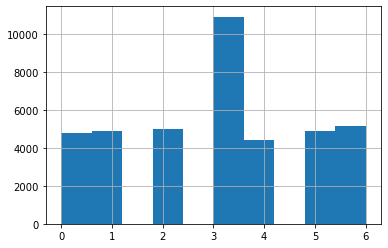

In [228]:
#посторим график посещения ресторанов по дням недели(будем считать, что день отзыва и посещения совпадают)
df['date1_week'].hist()

<AxesSubplot:>

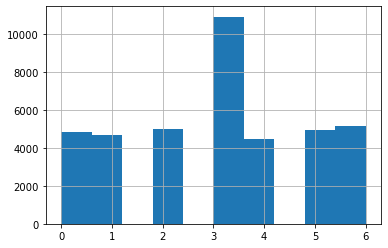

In [229]:
df['date2_week'].hist()

согласно приведенным выше графикам видно, что самый популярный день отзывов - четверг, что неожиданно. Можно предположить, что люди, которые были в заведении на выходных, к четвергу "созревают" для того, чтобы оставить отзыв

In [33]:
df.sample(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,range_of_price,cuisine_style_list,cuisine_count,time_reviews,date1,date2,date1_week,date2_week,dif_dates
3498,id_42,Krakow,"['Polish', 'Bar', 'European', 'International',...",43.0,4.5,$$ - $$$,538.0,"[['Great Cocktails', 'Casper & Greg!'], ['01/1...",/Restaurant_Review-g274772-d1770375-Reviews-Sc...,d1770375,2.0,"[Polish, Bar, European, International, Vegetar...",7,"[2018-01-11 00:00:00, 2018-01-07 00:00:00]",2018-01-11,2018-01-07,3.0,6.0,4.0
21411,id_55,Lisbon,"['Steakhouse', 'Mediterranean', 'European', 'P...",56.0,4.5,$$$$,987.0,"[['Excellent Experience!', 'Great Steak Better...",/Restaurant_Review-g189158-d7063650-Reviews-So...,d7063650,3.0,"[Steakhouse, Mediterranean, European, Portugue...",8,"[2018-02-14 00:00:00, 2018-02-09 00:00:00]",2018-02-14,2018-02-09,2.0,4.0,5.0
36124,id_2716,Milan,"['Italian', 'International', 'Vegan Options']",2718.0,5.0,$$ - $$$,5.0,"[[], []]",/Restaurant_Review-g187849-d10816049-Reviews-I...,d10816049,2.0,"[Italian, International, Vegan Options]",3,None,NaT,NaT,NaN,NaN,142.0
37089,id_3362,Milan,NaN,3364.0,5.0,$$ - $$$,2.0,"[['NICE BURGERS AND CHICKEN NUGGETS, CHEAP FO....",/Restaurant_Review-g187849-d10747371-Reviews-M...,d10747371,2.0,[],1,[2016-08-16 00:00:00],2016-08-16,2016-08-16,1.0,1.0,142.0
19452,id_4900,Barcelona,"['Cafe', 'Mediterranean']",4901.0,4.5,$$ - $$$,5.0,"[['Great atmosphere', 'Decent healthy meal a c...",/Restaurant_Review-g187497-d7295597-Reviews-El...,d7295597,2.0,"[Cafe, Mediterranean]",2,"[2015-05-19 00:00:00, 2014-12-07 00:00:00]",2015-05-19,2014-12-07,1.0,6.0,163.0


проанализируем кол-во ресторанов

In [167]:
df['restaurant_id'].value_counts()

id_436      18
id_227      18
id_871      18
id_633      18
id_585      17
            ..
id_15538     1
id_7962      1
id_11712     1
id_5431      1
id_13372     1
Name: restaurant_id, Length: 11909, dtype: int64

очевидно, что некоторые рестораны встречаются несколько раз, те являются сетевыми. присвоим таким ресторанам признак сети

In [18]:
resto_list = df['restaurant_id'].value_counts()
chain_restaurant = resto_list[resto_list>1]
chain_restaurant

id_227      18
id_871      18
id_633      18
id_436      18
id_430      17
            ..
id_10764     2
id_5980      2
id_12573     2
id_9207      2
id_4007      2
Name: restaurant_id, Length: 7204, dtype: int64

In [52]:
df['chain_restaurant'] = df['restaurant_id'].apply(lambda x: 1 if x in chain_restaurant else 0)
df['chain_restaurant'].value_counts()

1    35295
0     4705
Name: chain_restaurant, dtype: int64

<AxesSubplot:>

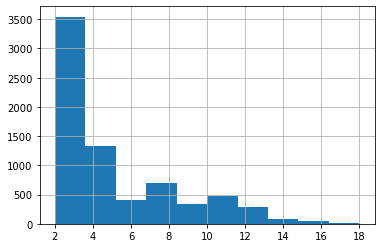

In [183]:
chain_restaurant.hist()

как видно из графика - сетевые рестораны, в основном, представлены 2мя заведениями

рассмотрим, как распределены по городам сетевые рестораны

<AxesSubplot:>

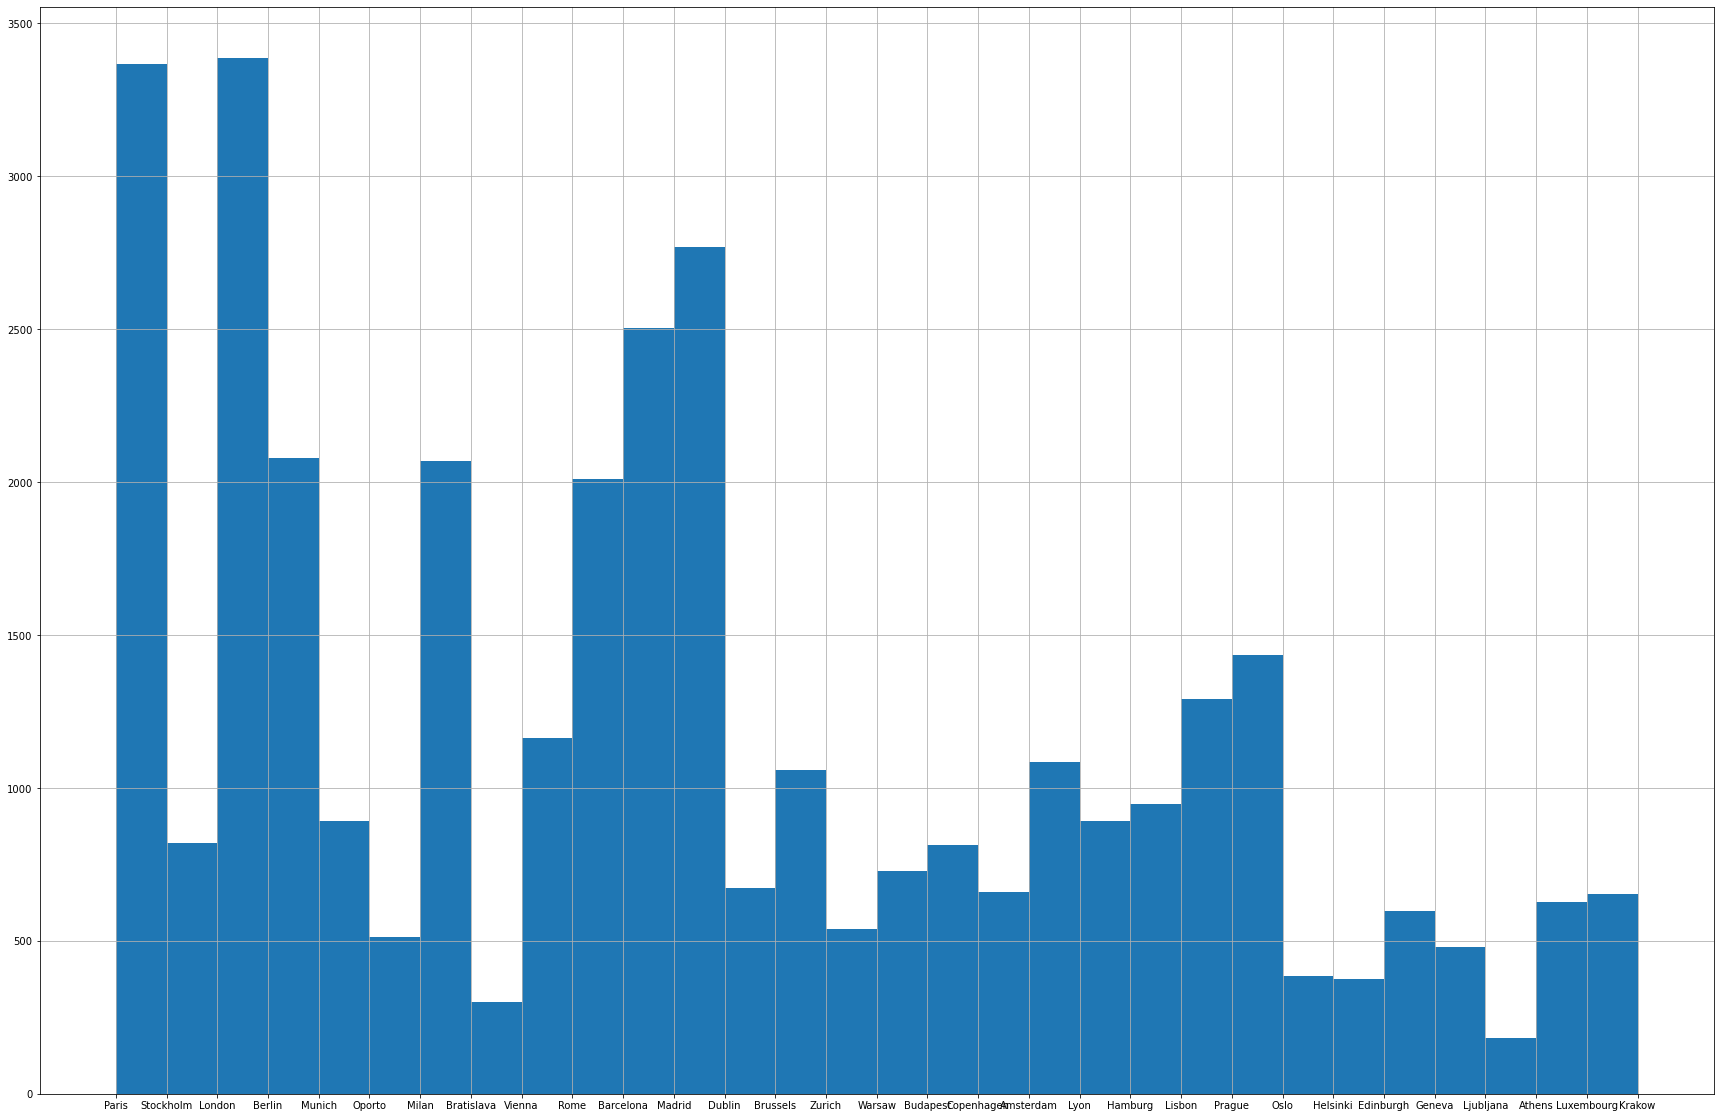

In [204]:
df['city'][df['chain_restaurant'] == 1].hist(bins = 30, figsize=(30,20))

как видно - наибольшее кол-во сетевых ресторанов находится в Париже и Лондоне

города в нашем случае категориальные признаки, которые можно преобразовать в dummy-переменные. для этого воспользуемся методом get_dummies

In [51]:
#разделение городов на dummy-переменные сохраним в одтельный датафрейм, который затем присоединим к основному, чтобы не терять города
df2 = pd.get_dummies(df, columns=[ 'city',], dummy_na=True)
df2

,restaurant_id,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,cuisine_style_list,...,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
0,id_5569,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[European, French, International]",...,0,0,1,0,0,0,0,0,0,0
1,id_1535,NaN,1537.0,4.0,$$ - $$$,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,[],...,0,0,0,0,0,1,0,0,0,0
2,id_352,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",...,0,0,0,0,0,0,0,0,0,0
3,id_3456,NaN,3458.0,5.0,$$ - $$$,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,[],...,0,0,0,0,0,0,0,0,0,0
4,id_615,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"[German, Central European, Vegetarian Friendly]",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,"[Italian, Vegetarian Friendly, Vegan Options, ...",...,0,0,0,0,0,0,0,0,0,0
39996,id_6340,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,"[French, American, Bar, European, Vegetarian F...",...,0,0,1,0,0,0,0,0,0,0
39997,id_1649,"['Japanese', 'Sushi']",1652.0,4.5,$$ - $$$,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,"[Japanese, Sushi]",...,0,0,0,0,0,1,0,0,0,0
39998,id_640,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,"[Polish, European, Eastern European, Central E...",...,0,0,0,0,0,0,0,1,0,0


In [52]:
df = df.merge(df2, how='right', on = 'restaurant_id' )
df.head(5)

,restaurant_id,city,cuisine_style_x,ranking_x,rating_x,price_range_x,number_of_reviews_x,reviews_x,url_ta_x,id_ta_x,...,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,0,0,1,0,0,0,0,0,0,0
1,id_5569,Madrid,"['Mediterranean', 'Spanish']",5572.0,4.0,$$ - $$$,24.0,"[['Excellent food and outstanding service', 'F...",/Restaurant_Review-g187514-d2001176-Reviews-Di...,d2001176,...,0,0,1,0,0,0,0,0,0,0
2,id_5569,Milan,"['Italian', 'Mediterranean', 'Vegetarian Frien...",5572.0,3.0,$$ - $$$,127.0,"[['Beautiful Place', 'Lovely place and atmosph...",/Restaurant_Review-g187849-d12429519-Reviews-L...,d12429519,...,0,0,1,0,0,0,0,0,0,0
3,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,0,0,0,0,0,0,0,0,0,0
4,id_5569,Madrid,"['Mediterranean', 'Spanish']",5572.0,4.0,$$ - $$$,24.0,"[['Excellent food and outstanding service', 'F...",/Restaurant_Review-g187514-d2001176-Reviews-Di...,d2001176,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   restaurant_id       40000 non-null  object        
 1   city                40000 non-null  object        
 2   cuisine_style       30717 non-null  object        
 3   ranking             40000 non-null  float64       
 4   rating              40000 non-null  float64       
 5   price_range         40000 non-null  object        
 6   number_of_reviews   37457 non-null  float64       
 7   reviews             40000 non-null  object        
 8   url_ta              40000 non-null  object        
 9   id_ta               40000 non-null  object        
 10  range_of_price      40000 non-null  float64       
 11  cuisine_style_list  40000 non-null  object        
 12  cuisine_count       40000 non-null  int64         
 13  time_reviews        33529 non-null  object    

проверим МАЕ, но сначала посмотрим наличие пропусков в новых признаках

In [ ]:
df.isna().sum()

In [265]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
# X = df.drop(['Restaurant_id', 'Rating'], axis = 1) 
X = df.drop(['restaurant_id', 'rating','cuisine_style','price_range','reviews','url_ta','id_ta', 'cuisine_style_list', 'time_reviews', 'date2', 'date1' ], axis = 1)
x_mean = np.mean(X['number_of_reviews']) 
X['number_of_reviews'] = X['number_of_reviews'].fillna(x_mean) #удаляем пропуски в серии:  
y = df['rating'] 

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X

,ranking,number_of_reviews,range_of_price,cuisine_count,date1_week,date2_week,dif_dates,chain_restaurant,city_Amsterdam,city_Athens,...,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
0,5570.0,194.0,2.0,3,6.000000,0.000000,41.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1537.0,10.0,2.0,1,3.000000,6.000000,382.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,353.0,688.0,3.0,7,0.000000,5.000000,2.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3458.0,3.0,2.0,1,3.010439,3.010439,142.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,621.0,84.0,2.0,3,5.000000,6.000000,272.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,79.0,2.0,4,5.000000,6.000000,34.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,6341.0,542.0,2.0,5,3.000000,1.000000,9.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
39997,1652.0,4.0,2.0,2,3.000000,5.000000,3127.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
39998,641.0,70.0,2.0,5,1.000000,6.000000,23.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [266]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
#для отслеживания прогресса создадим список, куда будем складывать каждый результат МАЕ

list_MAE.append(metrics.mean_absolute_error(y_test, y_pred)) #добавили первый МАЕ в список
print('MAE:', metrics.mean_absolute_error(y_test, y_pred)) 

MAE: 0.2144


In [267]:
list_MAE

[0.4272386701479077, 0.38860221587301585, 0.2144]

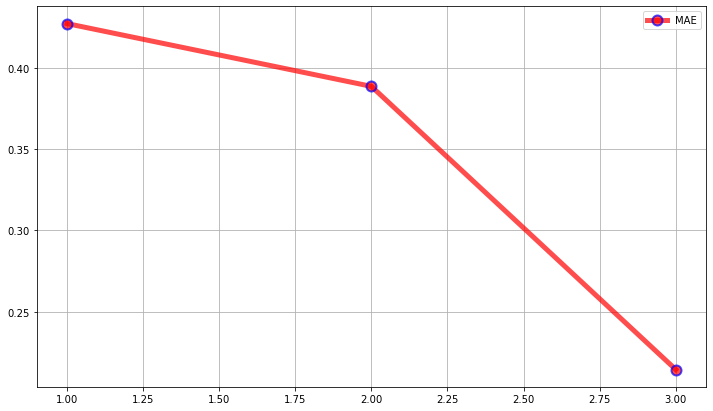

In [268]:
x = [1, 2, 3]
y1 = list_MAE
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="MAE", lw=5, mec='b', mew=2, ms=10)
plt.legend()
plt.grid(True)

очевидно, что преобразование городов в dummy-переменную благоприятно отразилось на качестве предсказания - МАЕ составил 0,21

визуализируем распредение признаков в дата сете

<AxesSubplot:xlabel='city'>

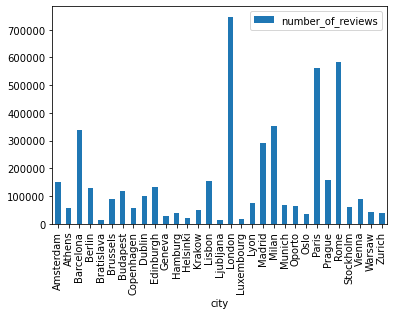

In [6]:
#соотношение колиства отзывов в каждом городе
df.pivot_table(values = ['number_of_reviews'], index = 'city', aggfunc = 'sum').plot(kind = 'bar')

из графика видно, что количество отзывов максимально в Лондоне, минимально - в Братиславе, Любляне и Лихтенштейне, что, скорее всего, связано с количеством жителей в этих городах

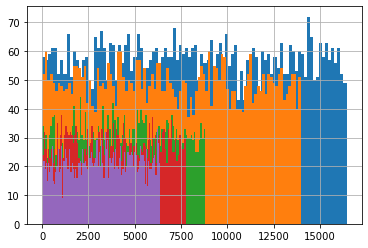

In [10]:
#распределение городского рейтинга ресторана среди топ-5 городов
for x in (df['city'].value_counts())[0:5].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.show()

видно, что распределение рейтинга среди городов соотносится с их численностью населения

<AxesSubplot:>

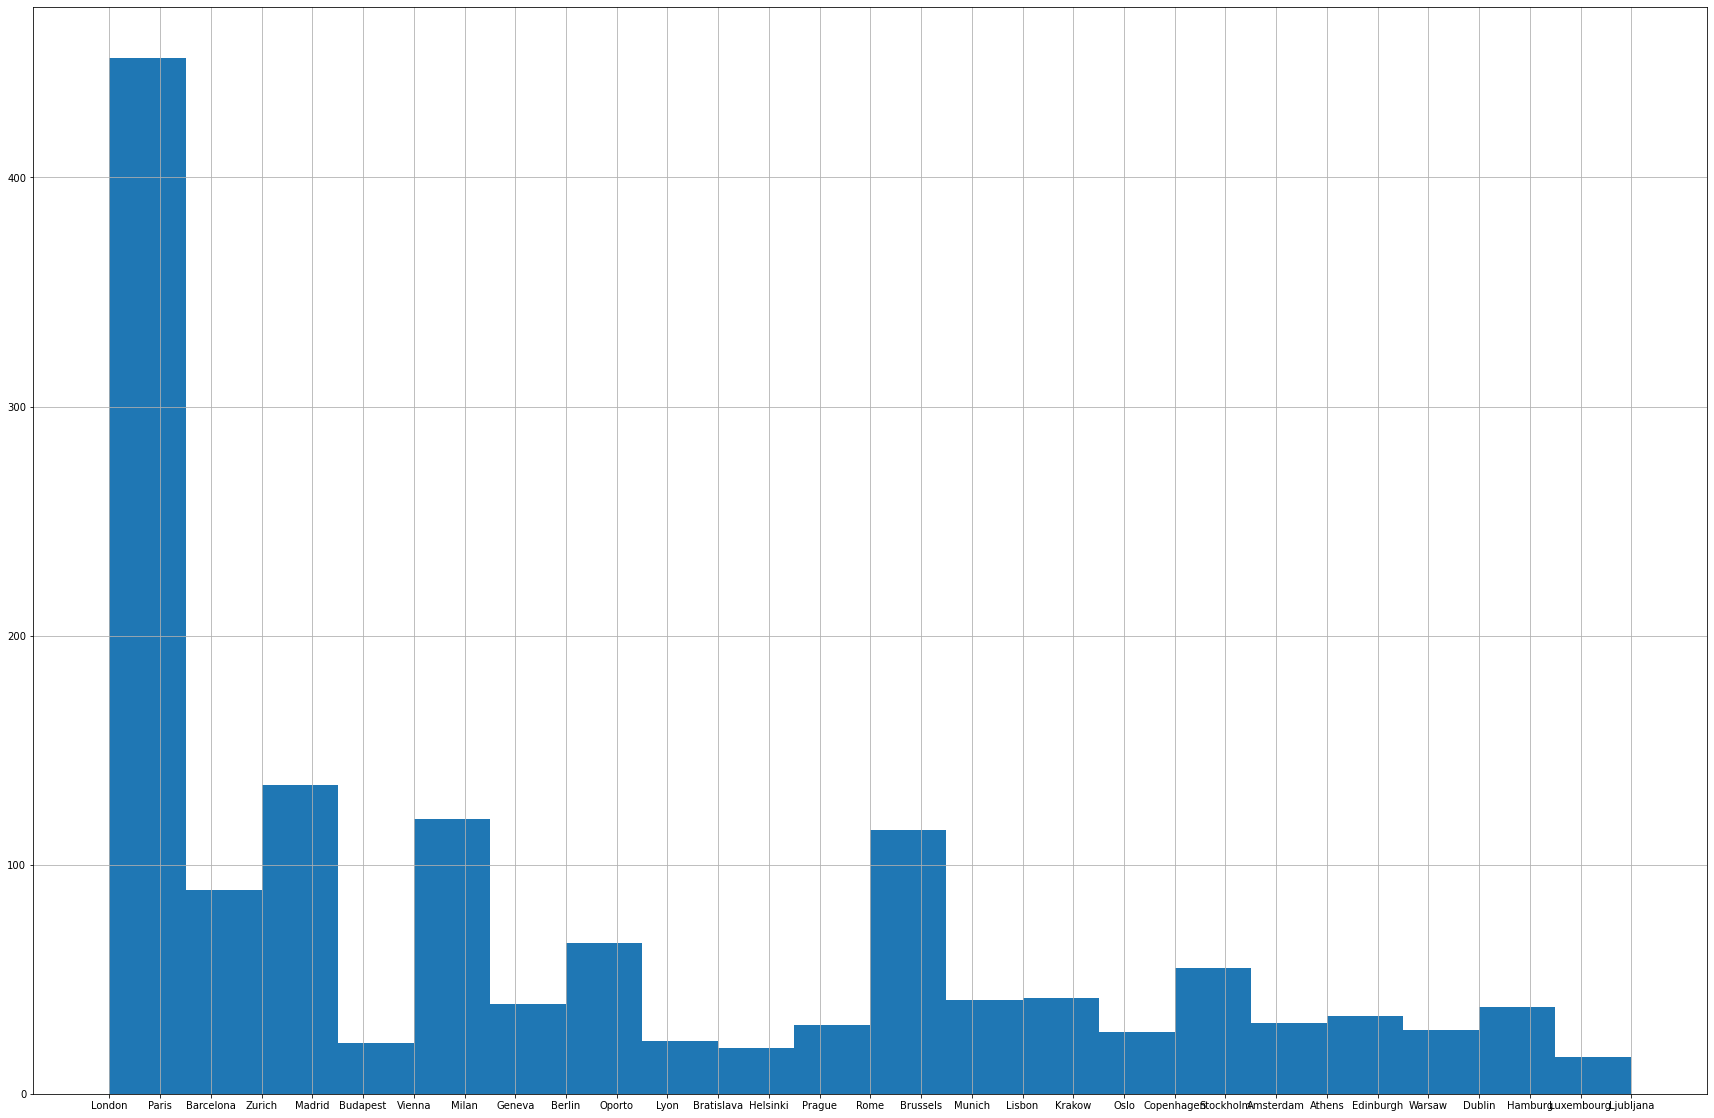

In [35]:
#распределение дорогих ресторанов среди городов
df['city'][df['range_of_price'] == 3].hist(bins=20, figsize=(30,20))

согласно графика - наибольшее количество ресторанов, где сумма чека относится к высокому ценовому диапзону, находится в Лондоне (не удивительно))